## The Quora Question Pair Similarity Problem 
### Duplicate Question Pairs - The Quora Question Pair Similarity Problem - End to End NLP Project - Heroku

### Introduction
Quora is a platform for Q & A, just like StackOverflow. But quora is more of a general-purpose Q & A platform that means there is not much code like in StackOverflow.

One of the many problems that quora face is the duplication of questions. Duplication of question ruins the experience for both the questioner and the answerer. Since the questioner is asking a duplicate question, we can just show him/her the answers to the previous question. And the answerer doesn’t have to repeat his/her answer for essentially the same questions.

For example, we have a question like “How can I be a good geologist?” and there are some answers to that question. Later someone else asks another question like “What should I do to be a great geologist?”.
We can see that both the questions are asking the same thing. Even though the wordings for the question are different, the intention of both questions is the same.

So the answers will be the same for both questions. That means we can just show the answers to the first question. That way the person who is asking the question will get the answers immediately and people who have answered already the first question don’t have to repeat themselves.

This problem is available on Kaggle as a competition. https://www.kaggle.com/c/quora-question-pairs
So given two questions, our main objective is to find whether they are similar. So let’s do some magic with ML. 🪄

### Business Objectives and Constraints

- There is no strict latency requirement.
- We would like to have interpretability but it is not absolutely mandatory.
- The cost of misclassification is medium.
- Both classes (duplicate or not) are equally important.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
# import pandas_profiling
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("train.csv")
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [4]:
df.shape

(404290, 6)

In [5]:
df.sample(10)

id    qid1    qid2  \
54865    54865   96803   96804   
303547  303547  426702  426703   
198684  198684  299977  299978   
206413  206413  309816  309817   
189784  189784  159922  288653   
361946  361946  491821    9768   
228348  228348  267316  337401   
125699  125699  169810   60761   
131563  131563  210894  210895   
315187  315187   45590   22175   

                                                question1  \
54865   How do I know if someone viewed my profile on ...   
303547  What are the worst things about being an archi...   
198684  India: What are your views on Sunny Leone's CN...   
206413                               What is your agenda?   
189784  How tall is Barron Trump? He seems fairly tall...   
361946  What is the next move that you suggest to Nare...   
228348  What is the meaning of "You are pretty, yourse...   
125699  Is curved spacetime the state of displacement ...   
131563  What was the sweetest thing you have ever hear...   
315187  How does the HP OfficeJet 4620 Airprint compar...   

                                                question2  is_duplicate  
54865   How do I known that someone viewed my Facebook...             1  
303547  Why do most velodrome olympians ride the Look ...             0  
198684  I really want to work in India. Do I have a ch...             0  
206413                                 What is an agenda?             0  
189784                Is 5.5 foot tall for a 13 year old?             0  
361946  What will be the next move by PM Modi to impro...             1  
228348  What does it mean to cut yourself short? What'...             0  
125699  Is the strongly interacting dark matter which ...             1  
131563    What is the sweetest thing someone said to you?             1  
315187  How does the HP OfficeJet 4620 Airprint compar...             1

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [7]:
# df.profile_report()

In [8]:
# missing values
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [9]:
# duplicate rows
df.duplicated().sum()

0

0    255027
1    149263
Name: is_duplicate, dtype: int64
0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64


<AxesSubplot:>

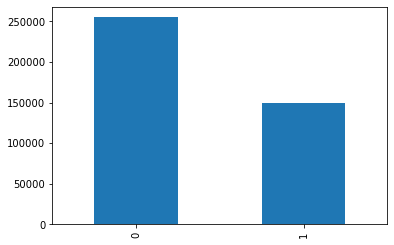

In [10]:
# Distribution of duplicate and non-duplicate questions

print(df['is_duplicate'].value_counts())
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)
df['is_duplicate'].value_counts().plot(kind='bar')

In [11]:
# Repeated questions

qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 537933
Number of questions getting repeated 111780


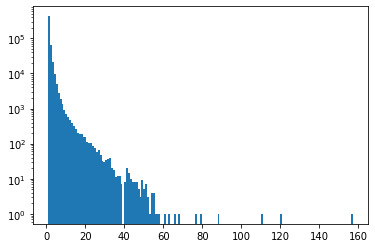

In [12]:
# Repeated questions histogram

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

# make data lighter select 30000 out of 400000

In [13]:
# df = pd.read_csv('train.csv')

In [14]:
new_df = df.sample(30000)

In [15]:
new_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [16]:
ques_df = new_df[['question1','question2']]
ques_df.head()

question1  \
19177                              What is substation?   
282955         Where can you advertise YouTube videos?   
139861  Why did French become a non pro-drop language?   
271532                  What is transmembrane protein?   
184231        Why do our eyes water when we feel pain?   

                                                question2  
19177                               What is a substation?  
282955  What are the views of Muslims towards those wh...  
139861             Why is French not a pro-drop language?  
271532  How do transmembrane proteins become transmemb...  
184231  Why is it that sometimes after closing our eye...

In [17]:
ques_df = new_df[['question1','question2']]
ques_df.head()

question1  \
19177                              What is substation?   
282955         Where can you advertise YouTube videos?   
139861  Why did French become a non pro-drop language?   
271532                  What is transmembrane protein?   
184231        Why do our eyes water when we feel pain?   

                                                question2  
19177                               What is a substation?  
282955  What are the views of Muslims towards those wh...  
139861             Why is French not a pro-drop language?  
271532  How do transmembrane proteins become transmemb...  
184231  Why is it that sometimes after closing our eye...

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [19]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [20]:
temp_df

0     1     2     3     4     5     6     7     8     9     ...  2990  \
19177      0     0     0     0     0     0     0     0     0     0  ...     0   
282955     0     0     0     0     0     0     0     0     0     0  ...     0   
139861     0     0     0     0     0     0     0     0     0     0  ...     0   
271532     0     0     0     0     0     0     0     0     0     0  ...     0   
184231     0     0     0     0     0     0     0     0     0     0  ...     0   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
53498      0     0     0     0     0     0     0     0     0     0  ...     0   
145102     0     0     0     0     0     0     0     0     0     0  ...     0   
272446     0     0     0     0     0     0     0     0     0     0  ...     0   
149197     0     0     0     0     0     0     0     0     0     0  ...     0   
226449     0     0     0     0     0     0     0     0     0     0  ...     0   

        2991  2992  2993  2994  2995  2996  2997  2998  2999  
19177      0     0     0     0     0     0     0     0     0  
282955     0     0     0     0     0     0     0     0     0  
139861     0     0     0     0     0     0     0     0     0  
271532     0     0     0     0     0     0     0     0     0  
184231     0     0     0     0     0     0     0     0     0  
...      ...   ...   ...   ...   ...   ...   ...   ...   ...  
53498      0     0     0     0     0     0     0     0     0  
145102     0     0     0     0     0     0     0     0     0  
272446     0     0     0     0     0     0     0     0     0  
149197     0     0     0     0     0     0     0     0     0  
226449     0     0     0     0     0     0     0     0     0  

[30000 rows x 6000 columns]

In [21]:
temp_df['is_duplicate'] = new_df['is_duplicate']

In [22]:
temp_df.head()

0  1  2  3  4  5  6  7  8  9  ...  2991  2992  2993  2994  2995  2996  \
19177   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
282955  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
139861  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
271532  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
184231  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

        2997  2998  2999  is_duplicate  
19177      0     0     0             1  
282955     0     0     0             0  
139861     0     0     0             1  
271532     0     0     0             0  
184231     0     0     0             0  

[5 rows x 6001 columns]

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(temp_df.iloc[:,0:-1].values,temp_df.iloc[:,-1].values,test_size=0.2,random_state=1)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7346666666666667

In [25]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

[22:10:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7285

0    18880
1    11120
Name: is_duplicate, dtype: int64
0    62.933333
1    37.066667
Name: is_duplicate, dtype: float64


<AxesSubplot:>

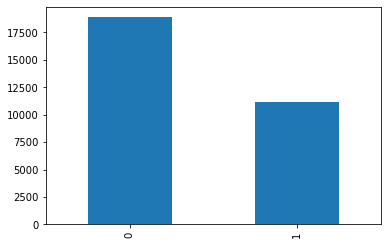

In [26]:
# Distribution of duplicate and non-duplicate questions

print(new_df['is_duplicate'].value_counts())
print((new_df['is_duplicate'].value_counts()/new_df['is_duplicate'].count())*100)
new_df['is_duplicate'].value_counts().plot(kind='bar')

In [27]:
# Repeated questions

qid = pd.Series(new_df['qid1'].tolist() + new_df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 55447
Number of questions getting repeated 3372


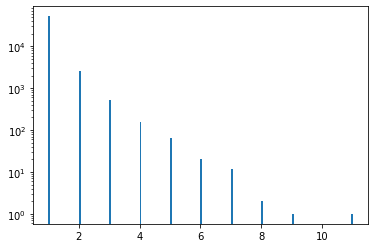

In [28]:
# Repeated questions histogram

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

## Add new Features to our dataset

In [29]:
# Feature Engineering

new_df['q1_len'] = new_df['question1'].str.len() 
new_df['q2_len'] = new_df['question2'].str.len()

In [30]:
new_df.head()

id    qid1    qid2  \
19177    19177   36263   36264   
282955  282955  402991  402992   
139861  139861  222370  222371   
271532  271532  228699  389631   
184231  184231  281526  281527   

                                             question1  \
19177                              What is substation?   
282955         Where can you advertise YouTube videos?   
139861  Why did French become a non pro-drop language?   
271532                  What is transmembrane protein?   
184231        Why do our eyes water when we feel pain?   

                                                question2  is_duplicate  \
19177                               What is a substation?             1   
282955  What are the views of Muslims towards those wh...             0   
139861             Why is French not a pro-drop language?             1   
271532  How do transmembrane proteins become transmemb...             0   
184231  Why is it that sometimes after closing our eye...             0   

        q1_len  q2_len  
19177       19      21  
282955      39      84  
139861      46      38  
271532      30      51  
184231      40     111

In [31]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df.head()

id    qid1    qid2  \
19177    19177   36263   36264   
282955  282955  402991  402992   
139861  139861  222370  222371   
271532  271532  228699  389631   
184231  184231  281526  281527   

                                             question1  \
19177                              What is substation?   
282955         Where can you advertise YouTube videos?   
139861  Why did French become a non pro-drop language?   
271532                  What is transmembrane protein?   
184231        Why do our eyes water when we feel pain?   

                                                question2  is_duplicate  \
19177                               What is a substation?             1   
282955  What are the views of Muslims towards those wh...             0   
139861             Why is French not a pro-drop language?             1   
271532  How do transmembrane proteins become transmemb...             0   
184231  Why is it that sometimes after closing our eye...             0   

        q1_len  q2_len  q1_num_words  q2_num_words  
19177       19      21             3             4  
282955      39      84             6            14  
139861      46      38             8             7  
271532      30      51             4             6  
184231      40     111             9            22

In [32]:
map(lambda word: word.lower().strip(), "What will be the positive and negative effects.".split(" "))

In [33]:
# convert all words in small letters and stip

list(map(lambda word: word.lower().strip(), "What will be the positive and negative effects.".split(" ")))

['what', 'will', 'be', 'the', 'positive', 'and', 'negative', 'effects.']

In [34]:
# replace list with set and eliminate duplicate words

set(map(lambda word: word.lower().strip(), "What will be the positive and negative effects.".split(" ")))

{'and', 'be', 'effects.', 'negative', 'positive', 'the', 'what', 'will'}

In [35]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

In [36]:
new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()

id    qid1    qid2  \
19177    19177   36263   36264   
282955  282955  402991  402992   
139861  139861  222370  222371   
271532  271532  228699  389631   
184231  184231  281526  281527   

                                             question1  \
19177                              What is substation?   
282955         Where can you advertise YouTube videos?   
139861  Why did French become a non pro-drop language?   
271532                  What is transmembrane protein?   
184231        Why do our eyes water when we feel pain?   

                                                question2  is_duplicate  \
19177                               What is a substation?             1   
282955  What are the views of Muslims towards those wh...             0   
139861             Why is French not a pro-drop language?             1   
271532  How do transmembrane proteins become transmemb...             0   
184231  Why is it that sometimes after closing our eye...             0   

        q1_len  q2_len  q1_num_words  q2_num_words  word_common  
19177       19      21             3             4            3  
282955      39      84             6            14            0  
139861      46      38             8             7            5  
271532      30      51             4             6            1  
184231      40     111             9            22            5

In [37]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [38]:
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()

id    qid1    qid2  \
19177    19177   36263   36264   
282955  282955  402991  402992   
139861  139861  222370  222371   
271532  271532  228699  389631   
184231  184231  281526  281527   

                                             question1  \
19177                              What is substation?   
282955         Where can you advertise YouTube videos?   
139861  Why did French become a non pro-drop language?   
271532                  What is transmembrane protein?   
184231        Why do our eyes water when we feel pain?   

                                                question2  is_duplicate  \
19177                               What is a substation?             1   
282955  What are the views of Muslims towards those wh...             0   
139861             Why is French not a pro-drop language?             1   
271532  How do transmembrane proteins become transmemb...             0   
184231  Why is it that sometimes after closing our eye...             0   

        q1_len  q2_len  q1_num_words  q2_num_words  word_common  word_total  
19177       19      21             3             4            3           7  
282955      39      84             6            14            0          20  
139861      46      38             8             7            5          15  
271532      30      51             4             6            1          10  
184231      40     111             9            22            5          28

In [39]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

id    qid1    qid2  \
19177    19177   36263   36264   
282955  282955  402991  402992   
139861  139861  222370  222371   
271532  271532  228699  389631   
184231  184231  281526  281527   

                                             question1  \
19177                              What is substation?   
282955         Where can you advertise YouTube videos?   
139861  Why did French become a non pro-drop language?   
271532                  What is transmembrane protein?   
184231        Why do our eyes water when we feel pain?   

                                                question2  is_duplicate  \
19177                               What is a substation?             1   
282955  What are the views of Muslims towards those wh...             0   
139861             Why is French not a pro-drop language?             1   
271532  How do transmembrane proteins become transmemb...             0   
184231  Why is it that sometimes after closing our eye...             0   

        q1_len  q2_len  q1_num_words  q2_num_words  word_common  word_total  \
19177       19      21             3             4            3           7   
282955      39      84             6            14            0          20   
139861      46      38             8             7            5          15   
271532      30      51             4             6            1          10   
184231      40     111             9            22            5          28   

        word_share  
19177         0.43  
282955        0.00  
139861        0.33  
271532        0.10  
184231        0.18

## EDA

minimum characters 1
maximum characters 370
average num of characters 59


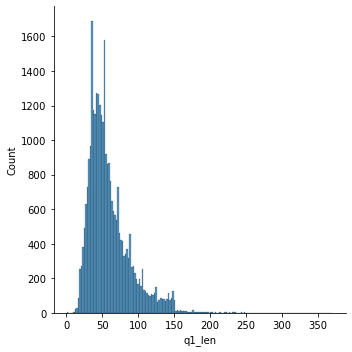

In [40]:
# Analysis of features
sns.displot(new_df['q1_len'])
print('minimum characters',new_df['q1_len'].min())
print('maximum characters',new_df['q1_len'].max())
print('average num of characters',int(new_df['q1_len'].mean()))

minimum characters 2
maximum characters 1169
average num of characters 60


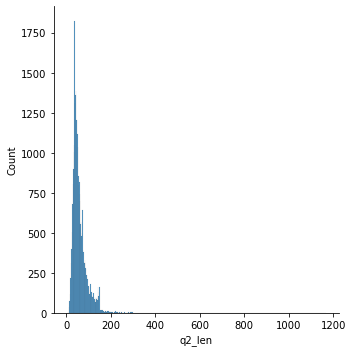

In [41]:
sns.displot(new_df['q2_len'])
print('minimum characters',new_df['q2_len'].min())
print('maximum characters',new_df['q2_len'].max())
print('average num of characters',int(new_df['q2_len'].mean()))

minimum words 1
maximum words 71
average num of words 10


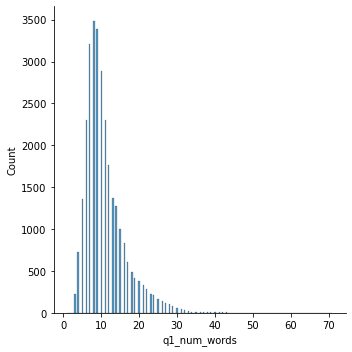

In [42]:
sns.displot(new_df['q1_num_words'])
print('minimum words',new_df['q1_num_words'].min())
print('maximum words',new_df['q1_num_words'].max())
print('average num of words',int(new_df['q1_num_words'].mean()))

minimum words 1
maximum words 228
average num of words 11


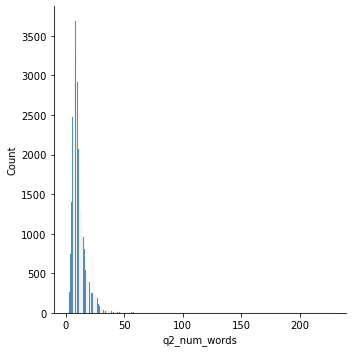

In [43]:
sns.displot(new_df['q2_num_words'])
print('minimum words',new_df['q2_num_words'].min())
print('maximum words',new_df['q2_num_words'].max())
print('average num of words',int(new_df['q2_num_words'].mean()))

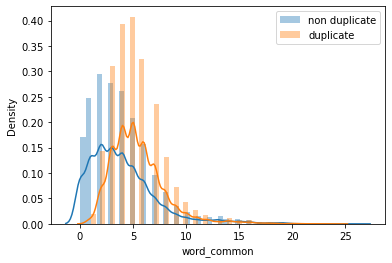

In [44]:
# common words
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_common'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_common'],label='duplicate')
plt.legend()
plt.show()

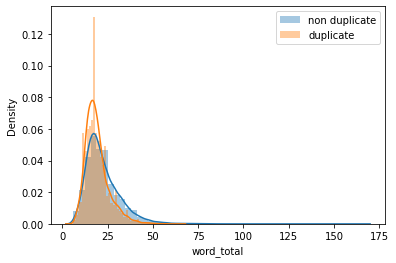

In [45]:
# total words
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_total'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_total'],label='duplicate')
plt.legend()
plt.show()

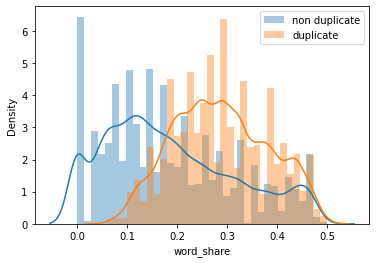

In [46]:
# word share
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

In [47]:
ques_df = new_df[['question1','question2']]
ques_df.head()

question1  \
19177                              What is substation?   
282955         Where can you advertise YouTube videos?   
139861  Why did French become a non pro-drop language?   
271532                  What is transmembrane protein?   
184231        Why do our eyes water when we feel pain?   

                                                question2  
19177                               What is a substation?  
282955  What are the views of Muslims towards those wh...  
139861             Why is French not a pro-drop language?  
271532  How do transmembrane proteins become transmemb...  
184231  Why is it that sometimes after closing our eye...

In [48]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(30000, 8)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  word_common  \
19177              1      19      21             3             4            3   
282955             0      39      84             6            14            0   
139861             1      46      38             8             7            5   
271532             0      30      51             4             6            1   
184231             0      40     111             9            22            5   

        word_total  word_share  
19177            7        0.43  
282955          20        0.00  
139861          15        0.33  
271532          10        0.10  
184231          28        0.18

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [50]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [51]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(30000, 6008)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  word_common  \
19177              1      19      21             3             4            3   
282955             0      39      84             6            14            0   
139861             1      46      38             8             7            5   
271532             0      30      51             4             6            1   
184231             0      40     111             9            22            5   

        word_total  word_share  0  1  ...  2990  2991  2992  2993  2994  2995  \
19177            7        0.43  0  0  ...     0     0     0     0     0     0   
282955          20        0.00  0  0  ...     0     0     0     0     0     0   
139861          15        0.33  0  0  ...     0     0     0     0     0     0   
271532          10        0.10  0  0  ...     0     0     0     0     0     0   
184231          28        0.18  0  0  ...     0     0     0     0     0     0   

        2996  2997  2998  2999  
19177      0     0     0     0  
282955     0     0     0     0  
139861     0     0     0     0  
271532     0     0     0     0  
184231     0     0     0     0  

[5 rows x 6008 columns]

In [52]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7706666666666667

In [79]:
# from xgboost import XGBClassifier
# xgb = XGBClassifier()
# xgb.fit(X_train,y_train)
# y_pred = xgb.predict(X_test)
# accuracy_score(y_test,y_pred)

In [78]:
from xgboost import XGBClassifier
xgb = XGBClassifier(eval_metric = "logloss")
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.7603333333333333

# Now how to increase further accuracy, lets create some new advanced features

## Advanced Features
### 1. Token Features
- cwc_min: This is the ratio of the number of common words to the length of the smaller question
- cwc_max: This is the ratio of the number of common words to the length of the larger question
- csc_min: This is the ratio of the number of common stop words to the smaller stop word count among the two questions
- csc_max: This is the ratio of the number of common stop words to the larger stop word count among the two questions
- ctc_min: This is the ratio of the number of common tokens to the smaller token count among the two questions
- ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions
- last_word_eq: 1 if the last word in the two questions is same, 0 otherwise
- first_word_eq: 1 if the first word in the two questions is same, 0 otherwise

### 2. Length Based Features
- mean_len: Mean of the length of the two questions (number of words)
- abs_len_diff: Absolute difference between the length of the two questions (number of words)
- longest_substr_ratio: Ratio of the length of the longest substring among the two questions to the length of the smaller question

### 3. Fuzzy Features
- fuzz_ratio: fuzz_ratio score from fuzzywuzzy
- fuzz_partial_ratio: fuzz_partial_ratio from fuzzywuzzy
- token_sort_ratio: token_sort_ratio from fuzzywuzzy
- token_set_ratio: token_set_ratio from fuzzywuzzy

In [55]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [56]:
new_df = df.sample(30000,random_state=2)
new_df.head()

id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  What is the best marketing automation tool for...   
115086  I am poor but I want to invest. What should I do?   
327711  I am from India and live abroad. I met a guy f...   
367788  Why do so many people in the U.S. hate the sou...   
151235                Consequences of Bhopal gas tragedy?   

                                                question2  is_duplicate  
398782  What is the best marketing automation tool for...             1  
115086  I am quite poor and I want to be very rich. Wh...             0  
327711  T.I.E.T to Thapar University to Thapar Univers...             0  
367788  My boyfriend doesnt feel guilty when he hurts ...             0  
151235  What was the reason behind the Bhopal gas trag...             0

In [57]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [58]:
import re
from bs4 import BeautifulSoup

In [59]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [60]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [61]:
new_df.head()

id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  is_duplicate  
398782  what is the best marketing automation tool for...             1  
115086  i am quite poor and i want to be very rich  wh...             0  
327711  t i e t to thapar university to thapar univers...             0  
367788  my boyfriend doesnt feel guilty when he hurts ...             0  
151235  what was the reason behind the bhopal gas tragedy             0

In [62]:
new_df['q1_len'] = new_df['question1'].str.len() 
new_df['q2_len'] = new_df['question2'].str.len()

In [63]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df.head()

id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  is_duplicate  \
398782  what is the best marketing automation tool for...             1   
115086  i am quite poor and i want to be very rich  wh...             0   
327711  t i e t to thapar university to thapar univers...             0   
367788  my boyfriend doesnt feel guilty when he hurts ...             0   
151235  what was the reason behind the bhopal gas tragedy             0   

        q1_len  q2_len  q1_num_words  q2_num_words  
398782      75      76            13            13  
115086      48      56            13            16  
327711     104     119            28            21  
367788      58     145            14            32  
151235      34      49             5             9

In [64]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

In [65]:
new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()

id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  is_duplicate  \
398782  what is the best marketing automation tool for...             1   
115086  i am quite poor and i want to be very rich  wh...             0   
327711  t i e t to thapar university to thapar univers...             0   
367788  my boyfriend doesnt feel guilty when he hurts ...             0   
151235  what was the reason behind the bhopal gas tragedy             0   

        q1_len  q2_len  q1_num_words  q2_num_words  word_common  
398782      75      76            13            13           12  
115086      48      56            13            16            8  
327711     104     119            28            21            4  
367788      58     145            14            32            1  
151235      34      49             5             9            3

In [66]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [67]:
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()

id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  is_duplicate  \
398782  what is the best marketing automation tool for...             1   
115086  i am quite poor and i want to be very rich  wh...             0   
327711  t i e t to thapar university to thapar univers...             0   
367788  my boyfriend doesnt feel guilty when he hurts ...             0   
151235  what was the reason behind the bhopal gas tragedy             0   

        q1_len  q2_len  q1_num_words  q2_num_words  word_common  word_total  
398782      75      76            13            13           12          26  
115086      48      56            13            16            8          24  
327711     104     119            28            21            4          38  
367788      58     145            14            32            1          34  
151235      34      49             5             9            3          13

In [68]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  is_duplicate  \
398782  what is the best marketing automation tool for...             1   
115086  i am quite poor and i want to be very rich  wh...             0   
327711  t i e t to thapar university to thapar univers...             0   
367788  my boyfriend doesnt feel guilty when he hurts ...             0   
151235  what was the reason behind the bhopal gas tragedy             0   

        q1_len  q2_len  q1_num_words  q2_num_words  word_common  word_total  \
398782      75      76            13            13           12          26   
115086      48      56            13            16            8          24   
327711     104     119            28            21            4          38   
367788      58     145            14            32            1          34   
151235      34      49             5             9            3          13   

        word_share  
398782        0.46  
115086        0.33  
327711        0.11  
367788        0.03  
151235        0.23

In [69]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [70]:
token_features = new_df.apply(fetch_token_features, axis=1)

new_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [71]:
new_df.head()

id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  is_duplicate  \
398782  what is the best marketing automation tool for...             1   
115086  i am quite poor and i want to be very rich  wh...             0   
327711  t i e t to thapar university to thapar univers...             0   
367788  my boyfriend doesnt feel guilty when he hurts ...             0   
151235  what was the reason behind the bhopal gas tragedy             0   

        q1_len  q2_len  q1_num_words  q2_num_words  ...  word_total  \
398782      75      76            13            13  ...          26   
115086      48      56            13            16  ...          24   
327711     104     119            28            21  ...          38   
367788      58     145            14            32  ...          34   
151235      34      49             5             9  ...          13   

        word_share   cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
398782        0.46  0.874989  0.874989  0.999980  0.999980  0.923070   
115086        0.33  0.666644  0.499988  0.714276  0.624992  0.583328   
327711        0.11  0.000000  0.000000  0.428565  0.272725  0.149999   
367788        0.03  0.000000  0.000000  0.000000  0.000000  0.000000   
151235        0.23  0.749981  0.599988  0.000000  0.000000  0.599988   

         ctc_max  last_word_eq  first_word_eq  
398782  0.923070           1.0            1.0  
115086  0.466664           1.0            1.0  
327711  0.115384           0.0            0.0  
367788  0.000000           0.0            0.0  
151235  0.333330           1.0            0.0  

[5 rows x 21 columns]

In [77]:
# !pip3 install Distance

In [73]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [74]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [75]:
new_df.head()

id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  is_duplicate  \
398782  what is the best marketing automation tool for...             1   
115086  i am quite poor and i want to be very rich  wh...             0   
327711  t i e t to thapar university to thapar univers...             0   
367788  my boyfriend doesnt feel guilty when he hurts ...             0   
151235  what was the reason behind the bhopal gas tragedy             0   

        q1_len  q2_len  q1_num_words  q2_num_words  ...   cwc_max   csc_min  \
398782      75      76            13            13  ...  0.874989  0.999980   
115086      48      56            13            16  ...  0.499988  0.714276   
327711     104     119            28            21  ...  0.000000  0.428565   
367788      58     145            14            32  ...  0.000000  0.000000   
151235      34      49             5             9  ...  0.599988  0.000000   

         csc_max   ctc_min   ctc_max  last_word_eq  first_word_eq  \
398782  0.999980  0.923070  0.923070           1.0            1.0   
115086  0.624992  0.583328  0.466664           1.0            1.0   
327711  0.272725  0.149999  0.115384           0.0            0.0   
367788  0.000000  0.000000  0.000000           0.0            0.0   
151235  0.000000  0.599988  0.333330           1.0            0.0   

        abs_len_diff  mean_len  longest_substr_ratio  
398782           0.0      13.0              0.855263  
115086           3.0      13.5              0.224490  
327711           6.0      23.0              0.047619  
367788          17.0      21.5              0.050847  
151235           4.0       7.0              0.542857  

[5 rows x 24 columns]

In [82]:
# !pip3 install fuzzywuzzy

In [81]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [83]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [84]:
print(new_df.shape)
new_df.head()

(30000, 28)


id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  is_duplicate  \
398782  what is the best marketing automation tool for...             1   
115086  i am quite poor and i want to be very rich  wh...             0   
327711  t i e t to thapar university to thapar univers...             0   
367788  my boyfriend doesnt feel guilty when he hurts ...             0   
151235  what was the reason behind the bhopal gas tragedy             0   

        q1_len  q2_len  q1_num_words  q2_num_words  ...   ctc_max  \
398782      75      76            13            13  ...  0.923070   
115086      48      56            13            16  ...  0.466664   
327711     104     119            28            21  ...  0.115384   
367788      58     145            14            32  ...  0.000000   
151235      34      49             5             9  ...  0.333330   

        last_word_eq  first_word_eq  abs_len_diff  mean_len  \
398782           1.0            1.0           0.0      13.0   
115086           1.0            1.0           3.0      13.5   
327711           0.0            0.0           6.0      23.0   
367788           0.0            0.0          17.0      21.5   
151235           1.0            0.0           4.0       7.0   

        longest_substr_ratio  fuzz_ratio  fuzz_partial_ratio  \
398782              0.855263          99                  99   
115086              0.224490          69                  67   
327711              0.047619          26                  29   
367788              0.050847          29                  41   
151235              0.542857          55                  70   

        token_sort_ratio  token_set_ratio  
398782                99               99  
115086                65               74  
327711                34               43  
367788                23               30  
151235                48               69  

[5 rows x 28 columns]

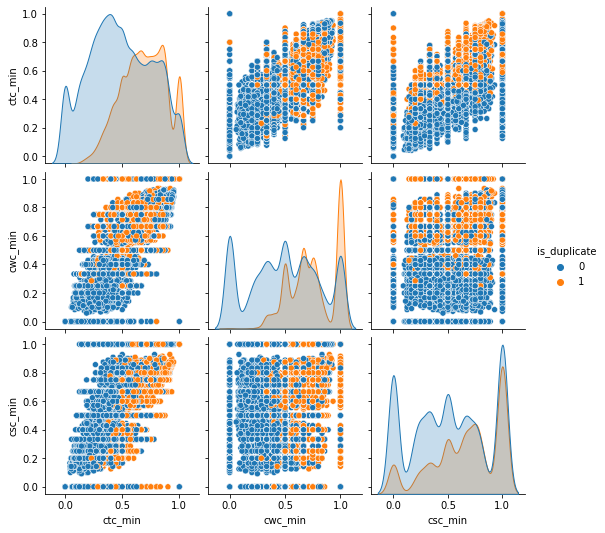

In [85]:
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

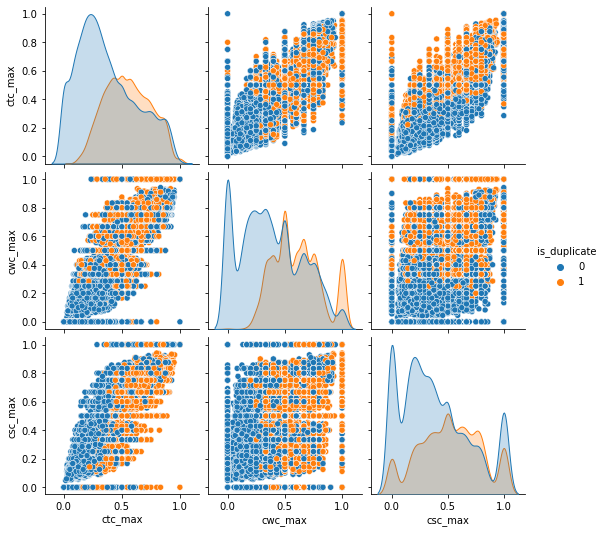

In [86]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

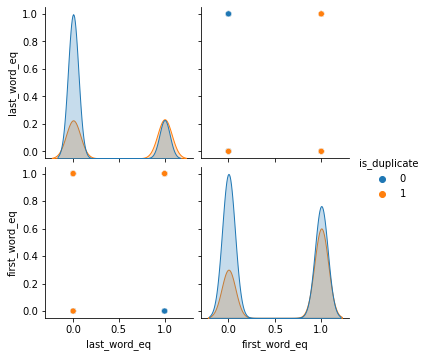

In [87]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

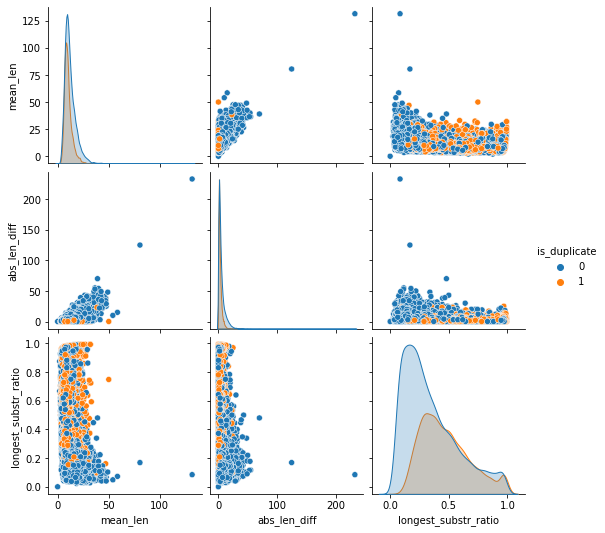

In [88]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

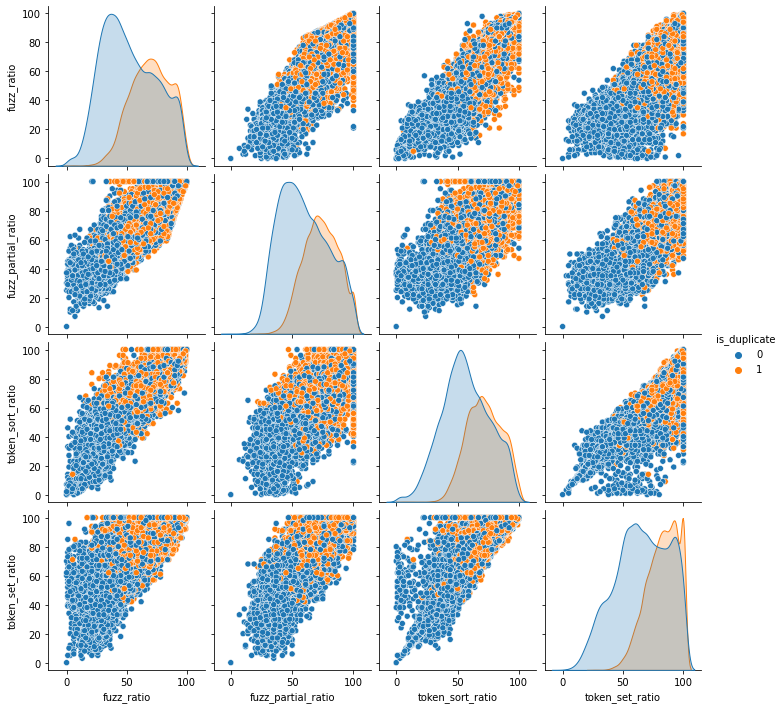

In [89]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [90]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(new_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = new_df['is_duplicate'].values

In [91]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.449s...
[t-SNE] Computed neighbors for 30000 samples in 6.827s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

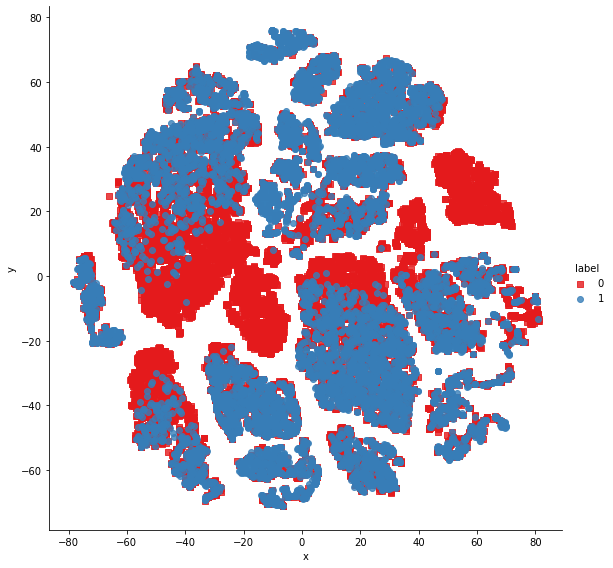

In [92]:
x_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=x_df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])

In [93]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.469s...
[t-SNE] Computed neighbors for 30000 samples in 9.281s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

In [94]:
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py
py.init_notebook_mode(connected=True)

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [96]:
ques_df = new_df[['question1','question2']]
ques_df.head()

question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  
398782  what is the best marketing automation tool for...  
115086  i am quite poor and i want to be very rich  wh...  
327711  t i e t to thapar university to thapar univers...  
367788  my boyfriend doesnt feel guilty when he hurts ...  
151235  what was the reason behind the bhopal gas tragedy

In [97]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(30000, 23)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  word_common  \
398782             1      75      76            13            13           12   
115086             0      48      56            13            16            8   
327711             0     104     119            28            21            4   
367788             0      58     145            14            32            1   
151235             0      34      49             5             9            3   

        word_total  word_share   cwc_min   cwc_max  ...   ctc_max  \
398782          26        0.46  0.874989  0.874989  ...  0.923070   
115086          24        0.33  0.666644  0.499988  ...  0.466664   
327711          38        0.11  0.000000  0.000000  ...  0.115384   
367788          34        0.03  0.000000  0.000000  ...  0.000000   
151235          13        0.23  0.749981  0.599988  ...  0.333330   

        last_word_eq  first_word_eq  abs_len_diff  mean_len  \
398782           1.0            1.0           0.0      13.0   
115086           1.0            1.0           3.0      13.5   
327711           0.0            0.0           6.0      23.0   
367788           0.0            0.0          17.0      21.5   
151235           1.0            0.0           4.0       7.0   

        longest_substr_ratio  fuzz_ratio  fuzz_partial_ratio  \
398782              0.855263          99                  99   
115086              0.224490          69                  67   
327711              0.047619          26                  29   
367788              0.050847          29                  41   
151235              0.542857          55                  70   

        token_sort_ratio  token_set_ratio  
398782                99               99  
115086                65               74  
327711                34               43  
367788                23               30  
151235                48               69  

[5 rows x 23 columns]

In [98]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [99]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [100]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(30000, 6023)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  word_common  \
398782             1      75      76            13            13           12   
115086             0      48      56            13            16            8   
327711             0     104     119            28            21            4   
367788             0      58     145            14            32            1   
151235             0      34      49             5             9            3   

        word_total  word_share   cwc_min   cwc_max  ...  2990  2991  2992  \
398782          26        0.46  0.874989  0.874989  ...     0     0     0   
115086          24        0.33  0.666644  0.499988  ...     0     0     0   
327711          38        0.11  0.000000  0.000000  ...     0     0     0   
367788          34        0.03  0.000000  0.000000  ...     0     0     0   
151235          13        0.23  0.749981  0.599988  ...     0     0     0   

        2993  2994  2995  2996  2997  2998  2999  
398782     0     0     0     0     0     0     0  
115086     0     0     0     0     0     0     0  
327711     0     0     0     0     0     0     0  
367788     1     0     0     0     0     0     0  
151235     0     0     0     0     0     0     0  

[5 rows x 6023 columns]

In [101]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7873333333333333

In [103]:
from xgboost import XGBClassifier
xgb = XGBClassifier(eval_metric = "logloss")
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.7926666666666666

In [104]:
from sklearn.metrics import confusion_matrix

In [105]:
# for random forest model
confusion_matrix(y_test,y_pred)

array([[3289,  523],
       [ 753, 1435]], dtype=int64)

In [106]:
# for xgboost model
confusion_matrix(y_test,y_pred1)

array([[3228,  584],
       [ 660, 1528]], dtype=int64)

In [107]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [108]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

In [109]:
def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [110]:
def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [111]:
def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [112]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()
    
    
    
    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

In [113]:
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of India?'

In [114]:
rf.predict(query_point_creator(q1,q4))

array([0], dtype=int64)

In [115]:
cv

CountVectorizer(max_features=3000)

In [116]:
import pickle

pickle.dump(rf,open('model.pkl','wb'))
pickle.dump(cv,open('cv.pkl','wb'))